# Carbon Intensity

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

<br>

### Data Preparation

We'll start by loading in the attribute data

In [2]:
attributes_fp = 'https://osuked.github.io/Power-Station-Dictionary/object_attrs/dictionary_attributes.csv'

df_attrs = pd.read_csv(attributes_fp)

df_attrs.head()

,attribute,id,value,datapackage,id_type,year,dictionary_id,financial_year
0,Fuel Type,MARK-1,BIOMASS,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,NaN,10000,NaN
1,Longitude,10000,-3.603516,https://raw.githubusercontent.com/OSUKED/Dicti...,dictionary_id,NaN,10000,NaN
2,Latitude,10000,57.480403,https://raw.githubusercontent.com/OSUKED/Dicti...,dictionary_id,NaN,10000,NaN
3,Annual Output (MWh),MARK-1,355704.933,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,2016.0,10000,NaN
4,Annual Output (MWh),MARK-1,387311.364,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,2017.0,10000,NaN


<br>

We'll then extract the CO2 emissions data

In [ ]:
def hide_spines(ax, positions=["top", "right"]):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), "Position must be passed as a list "

    for position in positions:
        ax.spines[position].set_visible(False)

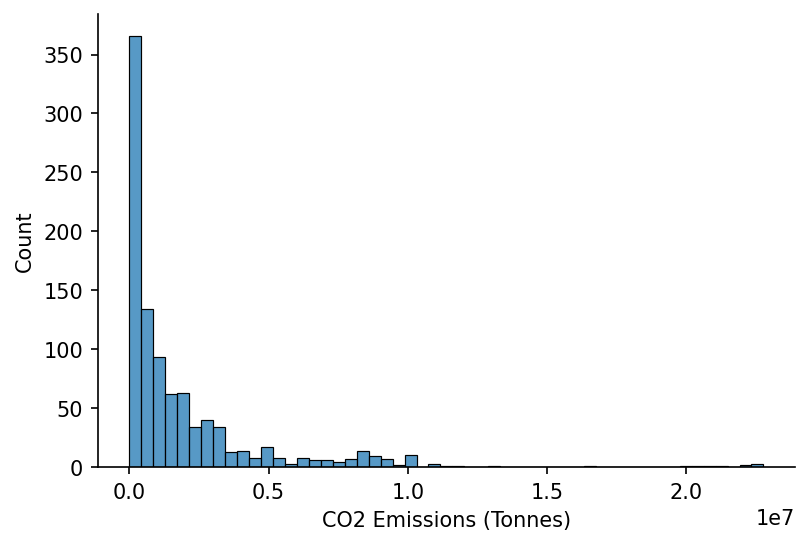

In [48]:
co2_attr = 'CO2 Emissions (Tonnes)'

s_site_co2 = (
    df_attrs
    .query('attribute==@co2_attr')
    [['dictionary_id', 'year', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'year': int, 'value': float})
    .groupby(['dictionary_id', 'year'])
    ['value']
    .sum()
)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_site_co2, ax=ax)

ax.set_xlabel(co2_attr)
hide_spines(ax)

<br>

As well as the power output data

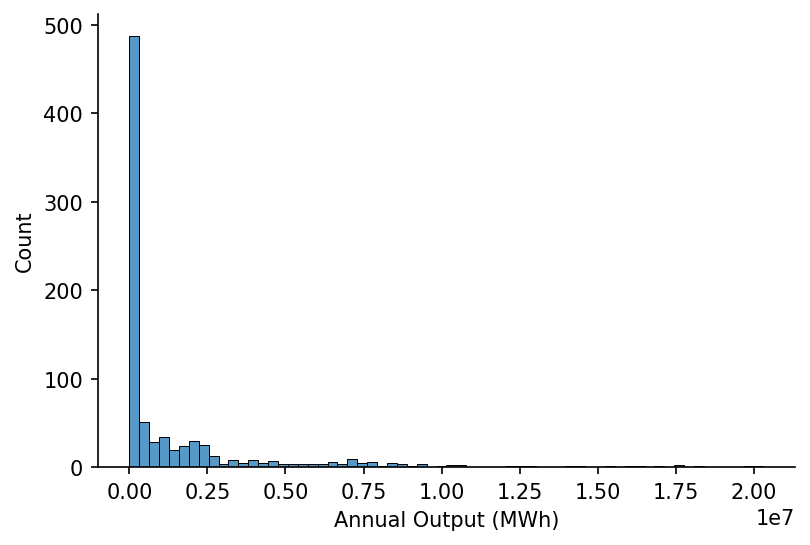

In [49]:
output_attr = 'Annual Output (MWh)'

s_site_output = (
    df_attrs
    .query('attribute==@output_attr')
    [['dictionary_id', 'year', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'year': int, 'value': float})
    .groupby(['dictionary_id', 'year'])
    ['value']
    .sum()
)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_site_output, ax=ax)

ax.set_xlabel(output_attr)
hide_spines(ax)

<br>

And lastly the fuel types of each plant

In [5]:
fuel_attr = 'Fuel Type'

s_site_fuel_type = (
    df_attrs
    .query('attribute==@fuel_attr')
    [['dictionary_id', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'value': str})
    .groupby('dictionary_id')
    ['value']
    .agg(lambda fuel_types: ', '.join(set(fuel_types)))
)

s_site_fuel_type.value_counts()

WIND                   112
CCGT                    34
NPSHYD                  13
NUCLEAR                  7
OCGT                     4
PS                       4
CCGT, OCGT               3
BIOMASS                  3
COAL, OCGT               1
CCGT, COAL, OCGT         1
Wind                     1
BIOMASS, OCGT, COAL      1
OTHER                    1
Name: value, dtype: int64

<br>

### Calculating Annual Carbon Intensities

We'll quickly check the data coverage

In [6]:
sites_with_co2_data = s_site_co2.index
sites_with_output_data = s_site_output.index

sites_with_both_datasets = sites_with_co2_data.intersection(sites_with_output_data)

sites_with_co2_data.size, sites_with_output_data.size, sites_with_both_datasets.size

(978, 825, 239)

In [7]:
sites_with_both_datasets.get_level_values(0).unique().size

52

<br>

We're now ready to calculate the annual carbon intensities

In [18]:
s_site_carbon_intensity = 1000 * s_site_co2.loc[sites_with_both_datasets]/s_site_output.loc[sites_with_both_datasets]

s_site_carbon_intensity

dictionary_id  year
10002          2016     856.556931
               2017     849.483513
               2018     933.703289
               2019     918.491921
               2020    3368.789243
                          ...     
10104          2016    1104.226297
               2017    1110.856183
               2018    1103.122391
               2019    1125.497186
               2020    1070.007876
Name: value, Length: 239, dtype: float64

<br>

We'll identify which sites we also have matched fuel type information for

In [29]:
s_site_fuel_type_mod = s_site_fuel_type.copy()

s_site_fuel_type_mod[s_site_fuel_type.str.contains(', ')] = 'MIXED'
s_site_fuel_type_mod = s_site_fuel_type_mod.replace('Wind', 'WIND')

sites_with_relevant_fuel_types = s_site_fuel_type_mod[s_site_fuel_type_mod.isin(['CCGT', 'OCGT', 'BIOMASS', 'MIXED'])].index

sites_with_relevant_fuel_types.size

47

<br>

We'll now filter for only thermal generation

In [59]:
s_site_focus_carbon_intensity = s_site_carbon_intensity.loc[s_site_carbon_intensity.index.get_level_values(0).isin(sites_with_relevant_fuel_types)]
s_site_focus_fuel_types = pd.Series(s_site_focus_carbon_intensity.index.get_level_values(0).map(s_site_fuel_type_mod.to_dict()), index=s_site_focus_carbon_intensity.index)

s_site_focus_carbon_intensity

dictionary_id  year
10004          2016     309.556085
               2017     306.054191
               2018     226.265042
               2019      50.052577
               2020      94.602010
                          ...     
10104          2016    1104.226297
               2017    1110.856183
               2018    1103.122391
               2019    1125.497186
               2020    1070.007876
Name: value, Length: 215, dtype: float64

<br>

Finally we're ready to save the dataset

In [47]:
s_site_focus_carbon_intensity.name = 'carbon_intensity_gco2_per_kwh'
s_site_focus_carbon_intensity = s_site_focus_carbon_intensity.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

s_site_focus_carbon_intensity.to_csv('../data/attribute_sources/carbon-intensity/carbon_intensity.csv', float_format='%.2f')

<br>

### Visualisations

Our first visualisation will be a scatter plot of carbon intensity against annual emissions

Text(0, 0.5, 'Annual Carbon Intensity (gCO2/kWh)')

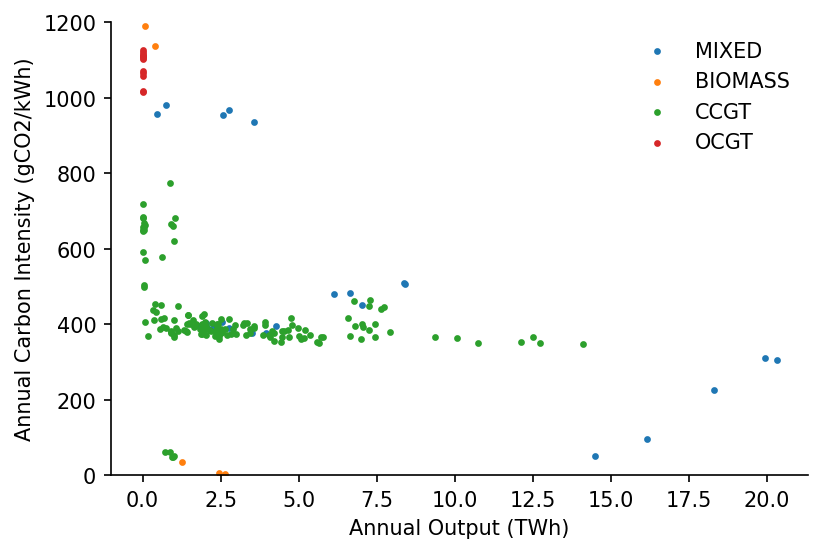

In [85]:
fuel_colour_map = {'BIOMASS': 'C1', 'MIXED': 'C0', 'CCGT': 'C2', 'OCGT': 'C3'}

# Plotting
fig, ax = plt.subplots(dpi=150)

for fuel_type in s_site_focus_fuel_types.unique():
    idxs = s_site_focus_fuel_types.index[s_site_focus_fuel_types==fuel_type]
    ax.scatter(s_site_output.loc[idxs].divide(1e6), s_site_focus_carbon_intensity.loc[idxs], c=fuel_colour_map[fuel_type], label=fuel_type, s=5)

hide_spines(ax)
ax.set_ylim(0, 1200)
ax.legend(frameon=False)
ax.set_xlabel('Annual Output (TWh)')
ax.set_ylabel('Annual Carbon Intensity (gCO2/kWh)')

<br>

And then create a histogram for only the OCGT and CCGT plants 

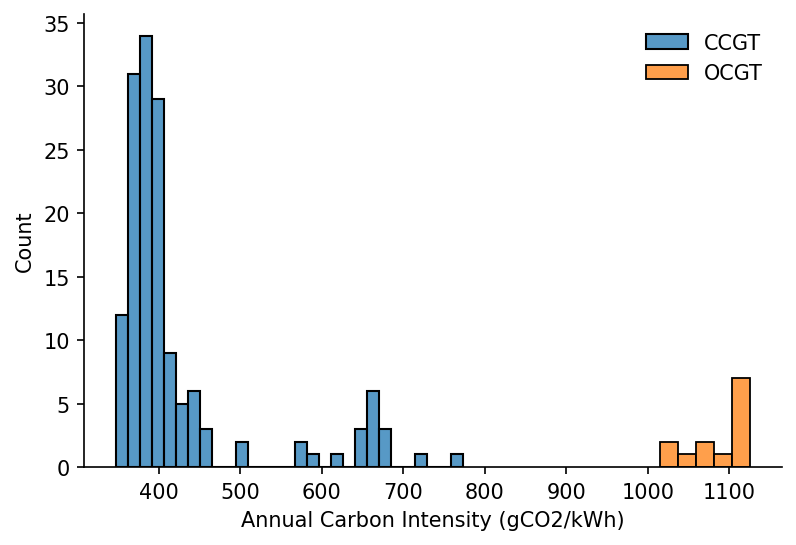

In [9]:
ccgt_sites = s_site_fuel_type.index[s_site_fuel_type=='CCGT'].intersection(s_site_co2.index.get_level_values(0)).intersection(s_site_output.index.get_level_values(0))
ocgt_sites = s_site_fuel_type.index[s_site_fuel_type=='OCGT'].intersection(s_site_co2.index.get_level_values(0)).intersection(s_site_output.index.get_level_values(0))

s_ccgt_carbon_intensities = 1000*(s_site_co2.loc[ccgt_sites]/s_site_output.loc[ccgt_sites]).dropna()
s_ccgt_carbon_intensities = s_ccgt_carbon_intensities.loc[(s_ccgt_carbon_intensities<1000)&(s_ccgt_carbon_intensities>200)]

s_ocgt_carbon_intensities = 1000*(s_site_co2.loc[ocgt_sites]/s_site_output.loc[ocgt_sites]).dropna()
s_ocgt_carbon_intensities = s_ocgt_carbon_intensities.loc[(s_ocgt_carbon_intensities<1200)&(s_ocgt_carbon_intensities>200)]

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_ccgt_carbon_intensities, ax=ax, label='CCGT')
sns.histplot(s_ocgt_carbon_intensities, ax=ax, color='C1', label='OCGT')

ax.set_xlabel('Annual Carbon Intensity (gCO2/kWh)')
hide_spines(ax)
ax.legend(frameon=False)